# Geotagging All Tweets  without Geolocation From Relevant Authors
***

**Project**: Master Thesis for MSc in Data Science for Decision Making

**Institution**: Barcelona School of Economics, Class of 2022

**Students**: Andrés Couble, Kalliope Stasssinos, Mathias Schindler

**Notebook Author**: Mathias Schindler

**Submission Date**: June 26, 2022

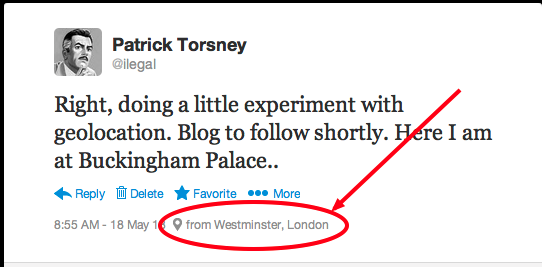

**NB**
<br>
This script is set up such that all manual input can be done in the subsection `preamble` and the script will run autonomously. In the end it will save a `.csv`-file that is restricted to Chilean Twitter users defined by the criteria in this notebook. 

**Criteria**
<br>
For observations to 'survive' this notebook, the features `author.description` or `author.location` should contain *at least* 1 of the folllowing textual characteristics:
* Contain a Chilean emoji flag 🇨🇱
* Contain the phrase 'chile' or a derivation thereof (e.g. 'chileno', 'chilena', etc.)
* Contain an unambiguous Chilean city either as an $n$-gram or a unigram

<br>
By "unambiguous" we mean a city name which is not also a city name in another country than Chile (so e.g. *not* 'Florida', 'Cartagena', 'San Carlos', 'Los Lagos', etc.).

**Execution Time**
<br>
MacBook Pro (2020-model) with a 2 GHz Quad-Core Intel Core i5 and 16 GB RAM runs this notebook in 1 hour, 16 min and 57 seconds. (See also the very last code cell which prints total execution time of notebook.)

### Preamble

In [1]:
# clear all
%reset -f
print(dir())

['In', 'Out', '__builtin__', '__builtins__', '__name__', '_dh', '_ih', '_oh', 'exit', 'get_ipython', 'quit']


**Manual input:** Set the path.

In [2]:
path='C:/Users/acoub/OneDrive/Desktop/DSDM/Thesis/ChileGov/methodology_feminism'
sep='/'

In [3]:
path_scripts = path+sep+'new_topic'
path_data= path+sep+'data'

In [4]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import random
import unidecode
from IPython.display import clear_output
import emoji
import textwrap
from wordcloud import WordCloud
from nltk.corpus import stopwords

from datetime import datetime

import pickle
import json
from twarc_csv import dataframe_converter
from twarc_csv import CSVConverter, DataFrameConverter

In [5]:
from MyPreprLib.myprepr import myprepr as custom
print(dir(custom))

# # Reload if changes
# import sys, importlib
# importlib.reload(sys.modules['MyPreprLib.myprepr.myprepr'])

# # Print arguments for functions
# print(custom.make_other_country_df.__code__.co_varnames)
# print(custom.city_dict_df.__code__.co_varnames)

['WordCloud', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'city_dict_df', 'cleanTweets', 'dict_regex_city', 'emoji', 'fix_na_loc_bio', 'make_other_country_df', 'np', 'pd', 're', 'regex_chile', 'stopwords', 'textwrap', 'tweets_preproz', 'unidecode', 'wordcloud_preproz']


In [6]:
notebook_start = datetime.now() #Start timer for entire notebook

In [7]:
# Setting: Show all columns in pd.DataFrame
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.options.display.max_colwidth = 200

# Resets
#pd.reset_option('display.max_colwidth')
#pd.reset_option('display.max_rows')

In [8]:
# Set name for exportet csv
out_filename ='filtered_by_location_updating.sav'
out_file = path_data + sep + out_filename
print(out_file)

C:/Users/acoub/OneDrive/Desktop/DSDM/Thesis/Methodology/data/filtered_by_location_updating.sav


# 1. Construct Author Location Features

## 1.0 Load Data, Set Lists

### 1.0.1 `twarc`-Data

In [9]:
# Load twarc data
converter = DataFrameConverter()
data = []
with open(path+sep+"data"+sep+"search_1_uploading.json") as f:
    for line in f:
        data.append(json.loads(line))
df = converter.process(data)

In [10]:
df.shape

(938, 74)

In [11]:
# Make list to run loop over 2 columns in df
cols_list_loop = ['author.location', 'author.description']

### 1.0.2 Wikipedia Tables

1) List of countries in the world in Spanish from Wikipedia (https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses):

In [12]:
# Set URL
paises_url = "https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses"

# Read html
paises_wiki = pd.read_html(paises_url, header = 0)

# Select table and columns
paises_wiki = paises_wiki[0]
paises_wiki = paises_wiki['Nombre común']

# Preprocess list with custom function "tweets_preproz()"
paises_wiki = pd.Series(paises_wiki)
paises_wiki = custom.tweets_preproz(df = paises_wiki, drop_na = False, drop_dup = True)

# Convert to list
pais_l = paises_wiki.to_list()

# Remove spacing some list elements
pais_l = ["".join(s.split()) for s in pais_l]
pais_l = [s.replace("/", "") for s in pais_l]
pais_l = [s.replace("-", "_") for s in pais_l]

2) **Manual input**: List of Chilean (country selected) cities from Wikipedia (https://en.wikipedia.org/wiki/List_of_cities_in_Chile):

In [13]:
# Set URL
cities_url = "https://en.wikipedia.org/wiki/List_of_cities_in_Chile"

# Read html
ch_cit = pd.read_html(cities_url, header = 0)

# Select table and columns
ch_cit = ch_cit[1]
ch_cit = ch_cit[['Region', 'City']] 

# Preprocessing 1: Lowercase
ch_cit = ch_cit.applymap(lambda s: s.lower() if type(s) == str else s) # lowercase

# Preprocessing 2: Remove "[note 2]/[note 3]"
ch_cit['Region'] = ch_cit['Region'].str.replace(r'\[note \d\]', '', regex=True)
ch_cit['City'] = ch_cit['City'].str.replace(r'\[note \d\]', '', regex=True)

# Preprocessing 3: Unidecode (remove accents and Spanish ñ)
ch_cit['Region'] = ch_cit['Region'].apply(unidecode.unidecode)
ch_cit['City'] = ch_cit['City'].apply(unidecode.unidecode)

# Concatenate both columns into one pandas series
ch_cit_con = pd.concat([ch_cit['Region'], ch_cit['City']])

# Drop duplicates
ch_cit_con = ch_cit_con.drop_duplicates()

# Convert to list
ch_reg_cit_uniq = ch_cit_con.to_list()

**Manual input**: 1.1 Emoji: Chilean Flag (selected country)

In [14]:
# Test
print('Demojized Chilean flag emoji is \n', emoji.demojize('🇨🇱'))

Demojized Chilean flag emoji is 
 :Chile:


In [15]:
start = datetime.now() #Start timer

for col in cols_list_loop:
    
# 1. Preprocess 
    # Demojize: Requires string and no NaN
    df[col] = df[col].astype("string").fillna("0")
    
    # Demojize: Apply function
    df[col] = df[col].apply(emoji.demojize)
    
#2. Make Boolean column if containing Chilean flag emoji
    if col == 'author.location':
        
        # Making new columns with custom function, regex_chile()
        new_col = 'loc_chile_emoji'
        loc_emoji_chile_flag = custom.regex_chile(df = df, col = col, 
                                                  colname = new_col)
        df = df.drop(new_col, axis = 1)
        
    elif col == 'author.description':
        
        # Making new columns with custom function, regex_chile()
        new_col = 'bio_chile_emoji'
        bio_emoji_chile_flag = custom.regex_chile(df = df, col = col, 
                                                  colname = new_col)
        df = df.drop(new_col, axis = 1)
        
    else:
        pass
    
print('Runtime:', datetime.now() - start) #Print runtime

Runtime: 0:00:00.108556


## 1.2 RegEx: Containing `'chile'`

Regular expression `'chile'` also captures 'chileno', 'chilena', etc.

In [16]:
start = datetime.now() #Start timer

for col in cols_list_loop:
    locs = df[col]
    
## 1.2 Data Preparation
    locs_pd = custom.tweets_preproz(df = locs, 
                             drop_na = True, 
                             drop_dup = True)

## 1.3 Filter with Regex
    # Find all author locations containing 'chile'
    locs_pd_dict = locs_pd[locs_pd.str.match(r'((.*?)chile(.*?))') == True]

# 2. Merge with Dataset
    # Convert dict to pd.DataFrame
    locs_df_dict = locs_pd_dict.to_frame()

## 2.2 Preprocessing given column
    df_preproz = df.copy()
    df_preproz[col] = custom.tweets_preproz(df = df_preproz[col], 
                                            drop_na = False, 
                                            drop_dup = False)
    
## 2.3 Implement Merging
    # Pre-Merge: Make df with boolean column all True
    df_chile_regex_tmp = df_preproz.merge(locs_df_dict, 
                                      on = col,
                                      validate = 'm:1')
    
    # Add boolean indiciator
    df_chile_regex_tmp['contains_chile'] = True

    # Keep only 2 cols
    df_chile_regex_tmp = df_chile_regex_tmp[['id', 'contains_chile']]

    # Print resulting df
    df_chile_regex = df_preproz.merge(df_chile_regex_tmp, 
                                      on = 'id',
                                      how = 'left',
                                      validate = '1:1',
                                      indicator = True)
    
    print('Proportion matched:', "{:.2f}".format(len(df_chile_regex_tmp)/len(df)*100),'%')

    # Rearrange columns
    new_col_order = ['id', 'conversation_id', 'author_id', 'author.description', 'author.location', 'contains_chile']
    df_chile_regex = df_chile_regex[new_col_order]
    
    if col == 'author.location':
        loc_regex_chile = df_chile_regex.rename(columns = {'contains_chile':'loc_contains_chile'})
        
    elif col == 'author.description':
        bio_regex_chile = df_chile_regex.rename(columns = {'contains_chile':'bio_contains_chile'})
        
    else:
        pass
    
print('Runtime:', datetime.now() - start) #Print runtime

Proportion matched: 29.00 %
Proportion matched: 12.47 %
Runtime: 0:00:00.439820


## 1.3 RegEx: Other Countries Than Chile

In [17]:
# For custom function "make_other_country_df()":
old_cols = ['any_count_not_chile', 'chile', 'afganistan', 'albania', 'alemania', 'andorra', 'angola', 
            'antiguaybarbuda', 'arabiasauditaarabiasaudi', 'argelia', 'argentina', 'armenia', 'australia', 
            'austria', 'azerbaiyan', 'bahamas', 'banglades', 'barbados', 'barein', 'belgica', 'belice', 'benin', 
            'bielorrusia', 'birmaniamyanmar', 'bolivia', 'botsuana', 'brasil', 'brunei', 'bulgaria', 'burkinafaso', 
            'burundi', 'butan', 'caboverde', 'camboya', 'camerun', 'canada', 'catar', 'republicacentroafricana', 
            'chad', 'republicachecachequia', 'china', 'chipre', 'colombia', 'comoras', 'republicadelcongo', 
            'republicademocraticadelcongo', 'coreadelnorte', 'coreadelsur', 'costademarfil', 'costarica', 
            'croacia', 'cuba', 'dinamarca', 'dominica', 'republicadominicana', 'ecuador', 'egipto', 'elsalvador', 
            'emiratosarabesunidos', 'eritrea', 'eslovaquia', 'eslovenia', 'espana', 'estadosunidos', 'estonia', 
            'etiopia', 'filipinas', 'finlandia', 'fiyi', 'francia', 'gabon', 'gambia', 'georgia', 'ghana', 
            'granada', 'grecia', 'guatemala', 'guinea', 'guineaecuatorial', 'guyana', 'haiti', 'honduras', 
            'hungria', 'india', 'indonesia', 'irak', 'iran', 'irlanda', 'islandia', 'israel', 'italia', 'jamaica', 
            'japon', 'jordania', 'kazajistan', 'kenia', 'kirguistan', 'kiribati', 'kuwait', 'laos', 'lesoto', 
            'letonia', 'libano', 'liberia', 'libia', 'liechtenstein', 'lituania', 'luxemburgo', 'macedoniadelnorte', 
            'madagascar', 'malasia', 'malaui', 'maldivas', 'malimali', 'malta', 'marruecos', 'islasmarshall', 
            'mauricio', 'mauritania', 'mexico', 'micronesia', 'moldavia', 'monaco', 'mongolia', 'montenegro', 
            'mozambique', 'namibia', 'nauru', 'nepal', 'nicaragua', 'niger', 'nigeria', 'noruega', 
            'nuevazelandanuevazelandia', 'oman', 'paisesbajos', 'pakistan', 'palaos', 'palestina', 'panama', 
            'papuanuevaguinea', 'paraguay', 'peru', 'polonia', 'portugal', 'reinounido', 'ruanda', 'rumaniarumania', 
            'rusia', 'islassalomon', 'samoa', 'sancristobalynieves', 'sanmarino', 'sanvicenteylasgranadinas', 
            'santalucia', 'santotomeyprincipe', 'senegal', 'serbia', 'seychelles', 'sierraleona', 'singapur', 
            'siria', 'somalia', 'srilanka', 'suazilandiaesuatini', 'sudafrica', 'sudan', 'sudandelsur', 'suecia', 
            'suiza', 'surinam', 'tailandia', 'tanzania', 'tayikistan', 'timororiental', 'togo', 'tonga', 
            'trinidadytobago', 'tunez', 'turkmenistan', 'turquia', 'tuvalu', 'ucrania', 'uganda', 'uruguay', 
            'uzbekistan', 'vanuatu', 'ciudaddelvaticano', 'venezuela', 'vietnam', 'yemen', 'yibuti', 'zambia', 
            'zimbabue']

In [18]:
start = datetime.now() #Start timer

for col in cols_list_loop:
## 1.1 Data Preparation
    locs = df[col]
    locs_pd = custom.tweets_preproz(df = locs, drop_na = False, drop_dup = False)
    
## 1.2 Filter with Regex
    ### 1.2.1 Identify Countries in Author Locs/bio using RegEx
    df_l = []
    
    for pais in pais_l:
        print("regex'ing:", col, ":", pais)
        # Make regular expression
        regex = '(.*?)' + pais + '(.*?)'

        # RegEx: Containing other country than Chile
        globals()['df_%s' % pais] = locs_pd[locs_pd.str.match(regex) == True]

        # Convert to df
        globals()['df_%s' % pais] = globals()['df_%s' % pais].to_frame()

        # Add boolean column
        globals()['df_%s' % pais][pais] = True

        # Remove other column
        globals()['df_%s' % pais] = globals()['df_%s' % pais].drop(col, axis = 1)
        
        # Give name to pd.DataFrame
        globals()['df_%s' % pais].name = str(pais)
        
        # Append to list
        df_l.append(globals()['df_%s' % pais])
        #df_l.remove("df_o'higgins")
        #df_l.remove("df_llay-llay")
    print("\n")
        
# 2. Merge with Dataset
## 2.1 Prepare df for Merge
    # Make copy
    df_preproz = df.copy()
    df_preproz[col] = custom.tweets_preproz(df = df_preproz[col], 
                                     drop_na = False, 
                                     drop_dup = False)
    
## 2.2 Implement Merging    
    # Loop over auxiliary dfs to merge with
    df_notchile_regex = df_preproz.copy()
    for l in df_l:
        print('merging:', col, ":", l.name)
        df_notchile_regex = df_notchile_regex.merge(l, how = 'left', left_index = True, right_index = True)
    print("\n")
        
# 3. Prepare each (of 2) df for export
    if col == 'author.location':
        loc_regex_othercountry = custom.make_other_country_df(old_cols = old_cols,
                                                              prefix = 'loc_', 
                                                              df_in = df_notchile_regex, 
                                                              bool_col_name = 'bool_any_count_not_chile', 
                                                              col_new_name = 'loc_any_other_country')
    elif col == 'author.description':
        bio_regex_othercountry = custom.make_other_country_df(old_cols = old_cols,
                                                              prefix = 'bio_', 
                                                              df_in = df_notchile_regex, 
                                                              bool_col_name = 'bool_any_count_not_chile', 
                                                              col_new_name = 'bio_any_other_country')
        
    else:
        pass
        
clear_output(); print('Runtime:', datetime.now() - start) #Print runtime

Runtime: 0:00:05.079408


## 1.4 Dictionary Method: Chilean Cities

### 1.4.1 Construct Dictionaries

In [19]:
## 2.1 – Dictionary A: List of Chilean Cities as $n$-Grams

# n-grams is same as output from previous cell
ch_cit_ngram = ch_reg_cit_uniq
print('List length n-grams:', len(ch_cit_ngram))

## 2.2 – Dictionary B: List of Chilean Cities as Unigrams

# Unigrams
ch_reg_cit_split = ' '.join(ch_reg_cit_uniq).split()
print('List length (after split):', len(ch_reg_cit_split))

#Remove duplicates
ch_reg_cit_split = list(dict.fromkeys(ch_reg_cit_split))

# Remove 'useless' words
ch_reg_cit_split.remove('los')
ch_reg_cit_split.remove('las')
ch_reg_cit_split.remove('el')
ch_reg_cit_split.remove('la')
ch_reg_cit_split.remove('lo')
ch_reg_cit_split.remove('de')
ch_reg_cit_split.remove('del')
ch_reg_cit_split.remove('san')
ch_reg_cit_split.remove('and')
ch_reg_cit_split.remove('region')

ch_cit_unigram = ch_reg_cit_split
print('\n List length Unigrams (no dups, no stopwords):', len(ch_cit_unigram))

List length n-grams: 243
List length (after split): 352

 List length Unigrams (no dups, no stopwords): 263


In [20]:
# Manually exclude ambiguous cities
n_grams_exclude = ['algarrobo', 'bulnes', 'cabildo', 'caldera', 'calle larga', 'cartagena', 
                   'casablanca', 'castro', 'colina', 'concepcion', 'constitucion', 'coronel',
                   'diego de almagro', 'el bosque', 'el melon', 'el monte', 'el salvador', 
                   'estacion central', 'freire', 'fresia', 'gorbea', 'graneros', 'hospital', 
                   'independencia', 'la calera', 'la cruz', 'la florida', 'la granja', 
                   'la islita', 'la laja', 'la reina', 'la serena', 'la union', 'labranza', 
                   'lampa', 'las cabras', 'las ventanas', 'lautaro', 'linares', 'lo espejo', 
                   'los alamos', 'los andes', 'los angeles', 'los lagos', 'los rios', 'lota', 
                   'magallanes', 'maria elena', 'mejillones', 'molina', 'mostazal', 
                   'nacimiento', 'nogales', 'osorno', 'padre hurtado', 'palmilla', 
                   'pedro aguirre cerda', 'penaflor', 'penco', 'peumo', 'providencia', 
                   'quintero', 'recoleta', 'rengo', 'rio bueno', 'rio negro', 'salamanca', 
                   'san antonio', 'san bernardo', 'san carlos', 'san clemente', 'san esteban', 
                   'san felipe', 'san fernando', 'san javier', 'san joaquin', 'san miguel', 
                   'san ramon', 'san rosendo', 'santa barbara', 'santa cruz', 'santa juana', 
                   'santa maria', 'santo domingo', 'teno', 'tome', 'victoria', 'vicuna', 'yungay']
unigrams_exclude = ['aguila', 'aguirre', 'agustin', 'alamos', 'alegre', 'alemana', 
                    'algarrobo', 'almagro', 'almonte', 'alto', 'amarilla', 'andes', 
                    'angeles', 'antonio', 'arenas', 'bajos', 'barbara', 'bernardo', 
                    'bosque', 'bueno', 'bulnes', 'cabildo', 'cabras', 'cabrero', 'caldera', 
                    'calle', 'carlos', 'cartagena', 'casablanca', 'casas', 'castro', 
                    'central', 'cerda', 'cerro', 'cisterna', 'clemente', 'colina', 
                    'concepcion', 'condes', 'constitucion', 'coronel', 'cruz', 'diego', 
                    'domingo', 'elena', 'espejo', 'estacion', 'esteban', 'felipe', 
                    'fernando', 'florida', 'freire', 'fresia', 'gorbea', 'granja', 
                    'hospicio', 'hospital', 'hurtado', 'imperial', 'independencia', 'isla', 
                    'islita', 'jahuel', 'javier', 'joaquin', 'jose', 'juana', 'labranza', 
                    'lagos', 'laja', 'lampa', 'larga', 'lautaro', 'linares', 'lota', 
                    'magallanes', 'mar', 'maria', 'mejillones', 'melon', 'metropolitan', 
                    'miguel', 'miranda', 'molina', 'monte', 'montt', 'mostazal', 
                    'nacimiento', 'natales', 'navia', 'negro', 'nogales', 'normal', 
                    'nueva', 'osorno', 'padre', 'palmilla', 'palqui', 'parral', 'patria', 
                    'paz', 'pedro', 'penaflor', 'penco', 'penuelas', 'peumo', 'pozo', 
                    'prado', 'providencia', 'puente', 'puerto', 'punta', 'quinta', 
                    'quintero', 'ramon', 'recoleta', 'reina', 'rengo', 'rinconada', 'rio', 
                    'rios', 'rosendo', 'salamanca', 'salvador', 'santa', 'santo', 'serena', 
                    'tabo', 'tagua', 'teno', 'tierra', 'tome', 'union', 'varas', 
                    'ventanas', 'vicente', 'victoria', 'vicuna', 'viejo', 'villa', 
                    'vina', 'yungay', 'zaldivar']

for city in n_grams_exclude:
    ch_cit_ngram.remove(city)
for city in unigrams_exclude:
    ch_cit_unigram.remove(city)
    
# Sort lists alphabetically
ch_cit_ngram.sort(); ch_cit_unigram.sort()
    
#Convert both (ngram + unigram) to dataframe
df_ch_cit_ngram = pd.DataFrame(ch_cit_ngram)
df_ch_cit_unigram = pd.DataFrame(ch_cit_unigram)

### 1.4.2 Apply Dictionary Method as `for` Loop

In [21]:
start = datetime.now() #Start timer

for col in cols_list_loop:
# 3. Preprocessing 'author.location' column
    # Make copy
    df_preproz = df.copy()
  
    # Preprocessing custom function "tweets_preproz()"
    df_preproz[col] = custom.tweets_preproz(df = df_preproz[col], 
                                            drop_na = False, 
                                            drop_dup = False)


# 4. Identify Regular Expressions in Author Locs / bio

##########################################################################
## 4.1 Identify Dict A ($n$-Grams) in Dataset
    
    # List with underscores
    ch_cit_ngram_var = [s.replace(" ", "_") for s in ch_cit_ngram]
    ch_cit_ngram_var = [s.replace("-", "_") for s in ch_cit_ngram_var]

    # Make dict
    ch_cit_ngram_dict = {ch_cit_ngram[i]: ch_cit_ngram_var[i] for i in range(len(ch_cit_ngram))}

    # Copy
    df_preproz_A = df_preproz.copy()

    # Make regular expression with custom function "dict_regex_city()"
    dfA_l = []
    
    for key, val in ch_cit_ngram_dict.items():
        print("regex'ing n-grams", col, ":", val)
        regex = '(.*?)' + key + '(.*?)'
        globals()['dfA_%s' % val] = custom.dict_regex_city(df_out_prefix = 'dfA', 
                                                           df_in = df_preproz_A, 
                                                           col = col, 
                                                           regex = regex, 
                                                           city = val)
        dfA_l.append(globals()['dfA_%s' % val])
    print("\n")

    # Loop over auxiliary dfs to merge with
    df_chile_cit_ngran = df_preproz.copy()
    for l in dfA_l:
        print('merging n-grams:', col, ":", l.name)
        df_chile_cit_ngran = df_chile_cit_ngran.merge(l, how = 'left', left_index = True, right_index = True)
    print("\n")
    
    # Rearrange + select cols
    old_cols = df_chile_cit_ngran.iloc[:, 74:].columns.to_list()
        
    if col == 'author.location':
        loc_city_ngram = custom.city_dict_df(prefix = 'loc_', 
                                             old_cols = old_cols,
                                             df_in = df_chile_cit_ngran, 
                                             bool_col_name = 'bool_loc_any_ngram_city', 
                                             col_new_name = 'loc_any_ngram_city')
        
    elif col == 'author.description':
        bio_city_ngram = custom.city_dict_df(prefix = 'bio_', 
                                             old_cols = old_cols,
                                             df_in = df_chile_cit_ngran, 
                                             bool_col_name = 'bool_bio_any_ngram_city', 
                                             col_new_name = 'bio_any_ngram_city')
        
    else:
        pass

    
##########################################################################
## 4.2 Identify Dict B (Unigrams) in Dataset
    df_l = []
    
    for n in ch_cit_unigram:
        # Make regular expression with custom function "dict_regex_city()"
        print("regex'ing unigrams:", col, ":", n)
        regex = '(.*?)' + n + '(.*?)'
        globals()['df_%s' % n] = custom.dict_regex_city(df_out_prefix = 'df', 
                                                        df_in = df_preproz, 
                                                        col = col, 
                                                        regex = regex, 
                                                        city = n)
        df_l.append(globals()['df_%s' % n])
    print("\n")

    # Loop over auxiliary dfs to merge with
    df_chile_cit_unig = df_preproz.copy()
    for l in df_l:
        print('merging unigrams:', col, ":", l.name)
        df_chile_cit_unig = df_chile_cit_unig.merge(l, how = 'left', left_index = True, right_index = True)
    print("\n")
        
    # Rearrange + select cols
    old_cols = df_chile_cit_unig.iloc[:, 74:].columns.to_list()
    
    if col == 'author.location':
        loc_city_unigram = custom.city_dict_df(prefix = 'loc_',
                                               old_cols = old_cols,
                                               df_in = df_chile_cit_unig, 
                                               bool_col_name = 'bool_loc_any_unigram_city', 
                                               col_new_name = 'loc_any_unigram_city')
    
    elif col == 'author.description':
        bio_city_unigram = custom.city_dict_df(prefix = 'bio_', 
                                               old_cols = old_cols,
                                               df_in = df_chile_cit_unig, 
                                               bool_col_name = 'bool_bio_any_unigram_city', 
                                               col_new_name = 'bio_any_unigram_city')
        
    else:
        pass

clear_output(); print('Runtime:', datetime.now() - start) #Print runtime

Runtime: 0:00:07.957707


### 1.5 Print Auxiliary Datasets

### 1.5.1 Emoji: Chilean Flag

In [ ]:
loc_emoji_chile_flag.head()

In [ ]:
bio_emoji_chile_flag.head()

### 1.5.2 RegEx: Containing `'Chile'`

In [ ]:
loc_regex_chile.head()

In [ ]:
bio_regex_chile.head()

### 1.5.3 RegEx: Other Countries Than Chile

In [ ]:
loc_regex_othercountry.head()

In [ ]:
bio_regex_othercountry.head()

### 1.5.4 Dictionary Method: Chilean Cities

In [ ]:
loc_city_ngram.head()

In [ ]:
bio_city_ngram.head()

In [ ]:
loc_city_unigram.head()

In [ ]:
bio_city_unigram.head()

# 2. Merge Auxiliary Datasets

## 2.0 Load Data, Set Lists

In [32]:
# Reload original twarc-file (making sure is raw)
start_df = df.copy()

# Select cols
start_df_cols = ['id', 'conversation_id', 'author.username', 'author.description', 'author.location']
start_df = start_df[start_df_cols]

In [33]:
loc_df_list = [loc_emoji_chile_flag, loc_regex_chile, loc_regex_othercountry, loc_city_ngram, loc_city_unigram]
bio_df_list = [bio_emoji_chile_flag, bio_regex_chile, bio_regex_othercountry, bio_city_ngram, bio_city_unigram]

## 2.1 Merge `loc` Auxiliary Datasets

In [34]:
start = datetime.now() #Start timer

# Merge auxiliary datasets:
for i in range(len(loc_df_list)):
    if i == 0:
        # Set dataframes to merge
        df1 = start_df; df2 = loc_df_list[i]
        
        # Select unique cols for dfs + 'id'
        cols_to_use = df2.columns.difference(df1.columns).to_list(); cols_to_use = ['id'] + cols_to_use
        
        # Merge
        loc_merged_df = df1.merge(df2[cols_to_use], on = 'id', validate = '1:1')
        
    else:
        # Set dataframes to merge
        df1 = loc_merged_df; df2 = loc_df_list[i]
        
        # Select unique cols for dfs + 'id'
        cols_to_use = df2.columns.difference(df1.columns).to_list(); cols_to_use = ['id'] + cols_to_use
        
        # Merge
        loc_merged_df = df1.merge(df2[cols_to_use], on = 'id', validate = '1:1')

        
###################################################################################
# Process resulting df
# Demojize author.location
for col in cols_list_loop:
    loc_merged_df[col] = loc_merged_df[col].astype("string").fillna("0")
    loc_merged_df[col] = loc_merged_df[col].apply(emoji.demojize)
    loc_merged_df[col] = loc_merged_df[col].replace('0', np.nan)

# Replace all new columns with False if NaN
my_cols = loc_merged_df.columns.to_list()
my_cols = my_cols[5:]

for col in my_cols:
    loc_merged_df[col] = loc_merged_df[col].replace(np.nan, False)
    

###################################################################################
#########        REORDER COLS              #########
# Reorder cols
# List of old cols
old_cols = loc_merged_df.columns.to_list()

# Ordered list og start cols
start_cols = start_df_cols + ['loc_chile_emoji', 'loc_contains_chile', 'loc_any_other_country', 
                              'loc_any_ngram_city', 'loc_any_unigram_city']

# Remove start cols from old list
for k in start_cols:
    old_cols.remove(k)

# New order
new_cols = start_cols + old_cols

# Reorder df
loc_merged_df = loc_merged_df[new_cols]

#########        MAKE RESITRCTIONS COL              #########
# Make one column to restrict on
restrict_cols = start_cols[5:]
restrict_cols.remove('loc_any_other_country')
loc_good_col = loc_merged_df[restrict_cols].any(axis = 1)

# Add restriction columns to merged_df
col_new_name = 'loc_good_col'
loc_to_restrict = pd.concat([loc_merged_df, loc_good_col], axis = 1)

# Rename, reorder, save
loc_to_restrict = loc_to_restrict.rename(columns = {0:col_new_name})
_ = loc_to_restrict.columns.to_list()
new_list = _[:5] + [col_new_name] + _[5:-1]
loc_to_restrict = loc_to_restrict[new_list]

    
print('Runtime:', datetime.now() - start) #Print runtime

Runtime: 0:00:00.927521


In [35]:
# Restrict: Keep only if either contains: 1) chile emoji, 2) 'chile', 3) n-gram chilean city, 4) unigram chilean city
df_loc_restrict = loc_to_restrict[loc_to_restrict.loc_good_col == True]

## 2.2 Merge `bio` Auxiliary Datasets

In [36]:
start = datetime.now() #Start timer

# Merge auxiliary datasets:
for i in range(len(bio_df_list)):
    if i == 0:
        # Set dataframes to merge
        df1 = start_df; df2 = bio_df_list[i]
        
        # Select unique cols for dfs + 'id'
        cols_to_use = df2.columns.difference(df1.columns).to_list(); cols_to_use = ['id'] + cols_to_use
        
        # Merge
        bio_merged_df = df1.merge(df2[cols_to_use], on = 'id', validate = '1:1')
        
    else:
        # Set dataframes to merge
        df1 = bio_merged_df; df2 = bio_df_list[i]
        
        # Select unique cols for dfs + 'id'
        cols_to_use = df2.columns.difference(df1.columns).to_list(); cols_to_use = ['id'] + cols_to_use
        
        # Merge
        bio_merged_df = df1.merge(df2[cols_to_use], on = 'id', validate = '1:1')

        
###################################################################################
# Process resulting df
# Demojize author.location
for col in cols_list_loop:
    bio_merged_df[col] = bio_merged_df[col].astype("string").fillna("0")
    bio_merged_df[col] = bio_merged_df[col].apply(emoji.demojize)
    bio_merged_df[col] = bio_merged_df[col].replace("0", np.nan)

# Replace all new columns with False if NaN
my_cols = bio_merged_df.columns.to_list()
my_cols = my_cols[5:]

for col in my_cols:
    bio_merged_df[col] = bio_merged_df[col].replace(np.nan, False)
    

###################################################################################
#########        REORDER COLS              #########
# Reorder cols
# List of old cols
old_cols = bio_merged_df.columns.to_list()

# Ordered list og start cols
start_cols = start_df_cols + ['bio_chile_emoji', 'bio_contains_chile', 'bio_any_other_country', 
                              'bio_any_ngram_city', 'bio_any_unigram_city']

# Remove start cols from old list
for k in start_cols:
    old_cols.remove(k)

# New order
new_cols = start_cols + old_cols

# Reorder df
bio_merged_df = bio_merged_df[new_cols]

#########        MAKE RESITRCTIONS COL              #########
# Make one column to restrict on
restrict_cols = start_cols[5:]
restrict_cols.remove('bio_any_other_country')
bio_good_col = bio_merged_df[restrict_cols].any(axis = 1)

# Add restriction columns to merged_df
col_new_name = 'bio_good_col'
bio_to_restrict = pd.concat([bio_merged_df, bio_good_col], axis = 1)

# Rename, reorder, save
bio_to_restrict = bio_to_restrict.rename(columns = {0:col_new_name})
_ = bio_to_restrict.columns.to_list()
new_list = _[:5] + [col_new_name] + _[5:-1]
bio_to_restrict = bio_to_restrict[new_list]

    
print('Runtime:', datetime.now() - start) #Print runtime

Runtime: 0:00:00.839998


In [37]:
# Restrict: Keep only if either contains: 1) chile emoji, 2) 'chile', 3) n-gram chilean city, 4) unigram chilean city
df_bio_restrict = bio_to_restrict[bio_to_restrict.bio_good_col == True]

# 3. Final Geo-Restricted Dataset

In [38]:
# Remove non-restriction cols for readability
loc_cols = df_loc_restrict.columns.to_list()
bio_cols = df_bio_restrict.columns.to_list()

# List of new cols order
new_cols = ['id', 'conversation_id', 'author.username', 'author.description_x', 'author.description_y',
            'author.location_x', 'author.location_y', 'loc_good_col', 'bio_good_col'] 
new_cols = new_cols + loc_cols[6:11] + bio_cols[6:11]

In [39]:
# Merge both datasets
df_loc_bio_merge = df_loc_restrict.merge(df_bio_restrict, 
                                         how = 'outer',
                                         on = ['id', 'conversation_id', 'author.username'], 
                                         validate = '1:1')

# Apply new columns list
df_loc_bio_merge = df_loc_bio_merge[new_cols]

# Fix if loc or bio is null
df_loc_bio_merge['author.description_x'] = custom.fix_na_loc_bio(df1 = df_loc_bio_merge['author.description_x'],
                                                          df2 = df_loc_bio_merge['author.description_y'])
df_loc_bio_merge['author.description_y'] = custom.fix_na_loc_bio(df1 = df_loc_bio_merge['author.description_y'],
                                                          df2 = df_loc_bio_merge['author.description_x'])
df_loc_bio_merge['author.location_x'] = custom.fix_na_loc_bio(df1 = df_loc_bio_merge['author.location_x'],
                                                       df2 = df_loc_bio_merge['author.location_y'])
df_loc_bio_merge['author.location_x'] = custom.fix_na_loc_bio(df1 = df_loc_bio_merge['author.location_x'],
                                                       df2 = df_loc_bio_merge['author.location_x'])

# Drop "_y"-cols
df_loc_bio_merge = df_loc_bio_merge.drop(['author.description_y', 'author.location_y'], axis = 1)

# Rename column
df_loc_bio_merge = df_loc_bio_merge.rename(columns={'author.description_x':'author.description',
                                                   'author.location_x':'author.location'})

# Replace NaN to False in new columns
cols_loc_bio_merge = df_loc_bio_merge.columns.to_list()
cols_loc_bio_merge = cols_loc_bio_merge[5:]
for col in cols_loc_bio_merge:
    df_loc_bio_merge[col] = df_loc_bio_merge[col].fillna(False)


In [40]:
print("Proportion matched from original twarc-data:", "{:.2f}".format(len(df_loc_bio_merge)/len(start_df)*100), "%")

Proportion matched from original twarc-data: 38.06 %


In [ ]:
df_loc_bio_merge.head(30)

# 4. Inspect

## 4.1 Random Samples

In [ ]:
df = df_loc_bio_merge
n_tweets = 10

for i in range(0, n_tweets):
    indexes = list(df.index) 
    a = random.choice(indexes)
    print('ID:', df['id'][a])
    print('Location:', df['author.location'][a])
    print('Description:', df['author.description'][a])
    print("")
    indexes.remove(a)

## 4.2 Visuals

Bar plot with top 20 author locations:

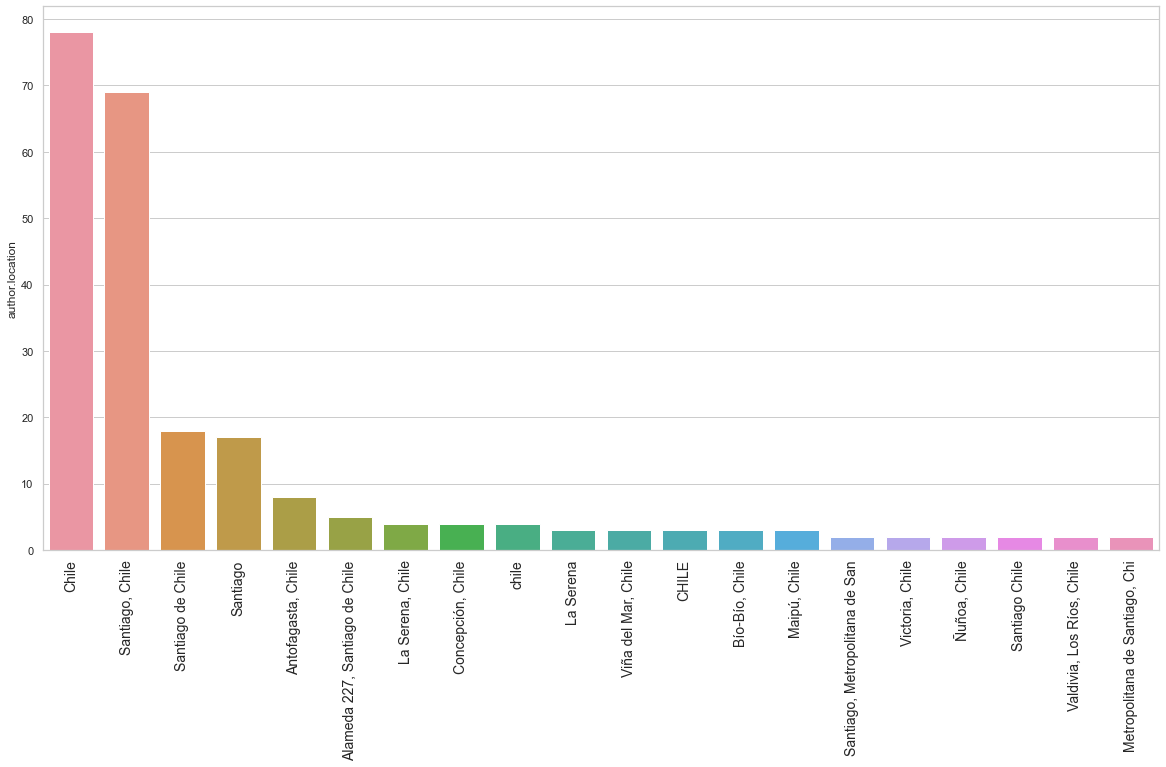

In [43]:
# Set data
df = df_loc_bio_merge

# General settings
sns.set_theme(style = "whitegrid")
plt.figure(figsize = (20, 10))

# Make figure
ax = sns.barplot(x = df['author.location'].value_counts().index[:20], 
                 y = df['author.location'].value_counts()[:20])
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, size = 14)

Wordcloud for author descriptions

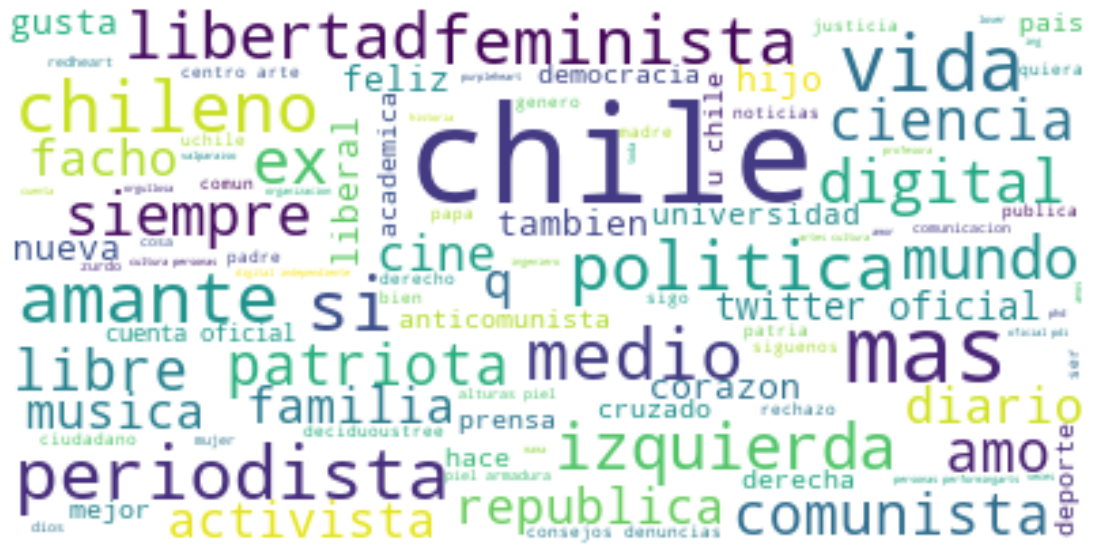

In [44]:
# For wordcloud all 'author.description' rows should be made into one long string 
textjoin = custom.wordcloud_preproz(df = df, col = 'author.description', hash_rm = True)
#print(textjoin[0:1000])

# Make wordcloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(textjoin)

# Display the generated image:
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off"); plt.show()

# 5. Export

In [45]:
# Export .sav-file
filename = path_data+sep+'filtered_by_location_updating.sav'
pickle.dump((df_loc_bio_merge), open(filename, 'wb'))

In [46]:
df_loc_bio_merge.shape

(357, 17)

In [47]:
#Print runtime
print('Runtime for entire notebook:', datetime.now() - notebook_start)

Runtime for entire notebook: 0:00:32.203579


In [ ]:
df_loc_bio_merge